###**Automatic License Plate Recognition for Distorted Images**
1. Plate detection and localization using W-pod Net.
2. Using Super-Resolution Generative Adversarial Network (SRGAN) to reconstruct the image.
3. Character Segmentation using contour/region based approach.
4. Optical character recognition using Support Vector Machine (SVM).

**1. Plate detection and localization**

* Using W-pod Net

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from os.path import splitext, basename
from keras.models import model_from_json
import glob
import matplotlib
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
# %matplotlib.inline

Method to load the W-pod Net.

In [ ]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)
        
wpod_net_path = "/content/drive/MyDrive/Colab Notebooks/ALPR/models/Plate_detect_and_recognize/wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


Preprocess the image before trying to obtain the localized image.

In [ ]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
   
    if resize:
        img = cv2.resize(img, (180,200))
    return img

Loading the image whose license plate needs to be detected and localized.

In [ ]:
image_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/ALPR/SISR/ALPR_Distorted/low_image /Image1.jpg')
print("Found {} images...".format(len(image_paths)))


Found 1 images...


In [ ]:
# pylint: disable=invalid-name, redefined-outer-name, missing-docstring, non-parent-init-called, trailing-whitespace, line-too-long
class Label:
    def __init__(self, cl=-1, tl=np.array([0., 0.]), br=np.array([0., 0.]), prob=None):
        self.__tl = tl
        self.__br = br
        self.__cl = cl
        self.__prob = prob

    def __str__(self):
        return 'Class: %d, top left(x: %f, y: %f), bottom right(x: %f, y: %f)' % (
        self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

    def copy(self):
        return Label(self.__cl, self.__tl, self.__br)

    def wh(self): return self.__br - self.__tl

    def cc(self): return self.__tl + self.wh() / 2

    def tl(self): return self.__tl

    def br(self): return self.__br

    def tr(self): return np.array([self.__br[0], self.__tl[1]])

    def bl(self): return np.array([self.__tl[0], self.__br[1]])

    def cl(self): return self.__cl

    def area(self): return np.prod(self.wh())

    def prob(self): return self.__prob

    def set_class(self, cl):
        self.__cl = cl

    def set_tl(self, tl):
        self.__tl = tl

    def set_br(self, br):
        self.__br = br

    def set_wh(self, wh):
        cc = self.cc()
        self.__tl = cc - .5 * wh
        self.__br = cc + .5 * wh

    def set_prob(self, prob):
        self.__prob = prob

class DLabel(Label):
    def __init__(self, cl, pts, prob):
        self.pts = pts
        tl = np.amin(pts, axis=1)
        br = np.amax(pts, axis=1)
        Label.__init__(self, cl, tl, br, prob)

def getWH(shape):
    return np.array(shape[1::-1]).astype(float)

def IOU(tl1, br1, tl2, br2):
    wh1, wh2 = br1-tl1, br2-tl2
    assert((wh1 >= 0).all() and (wh2 >= 0).all())
    
    intersection_wh = np.maximum(np.minimum(br1, br2) - np.maximum(tl1, tl2), 0)
    intersection_area = np.prod(intersection_wh)
    area1, area2 = (np.prod(wh1), np.prod(wh2))
    union_area = area1 + area2 - intersection_area
    return intersection_area/union_area

def IOU_labels(l1, l2):
    return IOU(l1.tl(), l1.br(), l2.tl(), l2.br())

def nms(Labels, iou_threshold=0.5):
    SelectedLabels = []
    Labels.sort(key=lambda l: l.prob(), reverse=True)
    
    for label in Labels:
        non_overlap = True
        for sel_label in SelectedLabels:
            if IOU_labels(label, sel_label) > iou_threshold:
                non_overlap = False
                break

        if non_overlap:
            SelectedLabels.append(label)
    return SelectedLabels



def find_T_matrix(pts, t_pts):
    A = np.zeros((8, 9))
    for i in range(0, 4):
        xi = pts[:, i]
        xil = t_pts[:, i]
        xi = xi.T
        
        A[i*2, 3:6] = -xil[2]*xi
        A[i*2, 6:] = xil[1]*xi
        A[i*2+1, :3] = xil[2]*xi
        A[i*2+1, 6:] = -xil[0]*xi

    [U, S, V] = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

def getRectPts(tlx, tly, brx, bry):
    return np.matrix([[tlx, brx, brx, tlx], [tly, tly, bry, bry], [1, 1, 1, 1]], dtype=float)

def normal(pts, side, mn, MN):
    pts_MN_center_mn = pts * side
    pts_MN = pts_MN_center_mn + mn.reshape((2, 1))
    pts_prop = pts_MN / MN.reshape((2, 1))
    return pts_prop

# Reconstruction function from predict value into plate crpoped from image
def reconstruct(I, Iresized, Yr, lp_threshold):
    # 4 max-pooling layers, stride = 2
    net_stride = 2**4
    side = ((208 + 40)/2)/net_stride

    # one line and two lines license plate size
    one_line = (70, 50)
    two_lines = (70, 50)

    Probs = Yr[..., 0]
    Affines = Yr[..., 2:]

    xx, yy = np.where(Probs > lp_threshold)
    # CNN input image size 
    WH = getWH(Iresized.shape)
    # output feature map size
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha
    base = lambda vx, vy: np.matrix([[-vx, -vy, 1], [vx, -vy, 1], [vx, vy, 1], [-vx, vy, 1]]).T
    labels = []
    labels_frontal = []

    for i in range(len(xx)):
        x, y = xx[i], yy[i]
        affine = Affines[x, y]
        prob = Probs[x, y]

        mn = np.array([float(y) + 0.5, float(x) + 0.5])

        # affine transformation matrix
        A = np.reshape(affine, (2, 3))
        A[0, 0] = max(A[0, 0], 0)
        A[1, 1] = max(A[1, 1], 0)
        # identity transformation
        B = np.zeros((2, 3))
        B[0, 0] = max(A[0, 0], 0)
        B[1, 1] = max(A[1, 1], 0)

        pts = np.array(A*base(vxx, vyy))
        pts_frontal = np.array(B*base(vxx, vyy))

        pts_prop = normal(pts, side, mn, MN)
        frontal = normal(pts_frontal, side, mn, MN)

        labels.append(DLabel(0, pts_prop, prob))
        labels_frontal.append(DLabel(0, frontal, prob))
        
    final_labels = nms(labels, 0.1)
    final_labels_frontal = nms(labels_frontal, 0.1)

    #print(final_labels_frontal)
    assert final_labels_frontal, "No License plate is founded!"

    # LP size and type
    out_size, lp_type = (two_lines, 2) if ((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]) < 1.7) else (one_line, 1)

    TLp = []
    Cor = []
    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for _, label in enumerate(final_labels):
            t_ptsh = getRectPts(0, 0, out_size[0], out_size[1])
            ptsh = np.concatenate((label.pts * getWH(I.shape).reshape((2, 1)), np.ones((1, 4))))
            H = find_T_matrix(ptsh, t_ptsh)
            Ilp = cv2.warpPerspective(I, H, out_size, borderValue=0)
            TLp.append(Ilp)
            Cor.append(ptsh)
    return final_labels, TLp, lp_type, Cor

def detect_lp(model, I, max_dim, lp_threshold):
    min_dim_img = min(I.shape[:2])
    factor = float(max_dim) / min_dim_img
    w, h = (np.array(I.shape[1::-1], dtype=float) * factor).astype(int).tolist()
    Iresized = cv2.resize(I, (w, h))
    T = Iresized.copy()
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))
    Yr = model.predict(T)
    Yr = np.squeeze(Yr)
    #print(Yr.shape)
    L, TLp, lp_type, Cor = reconstruct(I, Iresized, Yr, lp_threshold)
    return L, TLp, lp_type, Cor


Detect 1 plate(s) in Image1


True

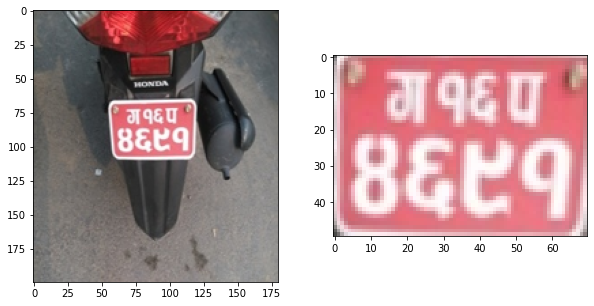

In [ ]:
def get_plate(image_path, Dmax=608, Dmin=168):
    vehicle = preprocess_image(image_path, resize = True)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

# Obtain plate image and its coordinates from an image
test_image = image_paths[0]
LpImg,cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
# print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis(True)
plt.imshow(preprocess_image(test_image, resize = True))
plt.subplot(1,2,2)
plt.axis(True)
plt.imshow(LpImg[0])

img_n = cv2.normalize(src=LpImg[0], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
img_n = cv2.cvtColor(img_n, cv2.COLOR_BGR2RGB)
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/ALPR/SISR/ALPR_Distorted/foo.jpg', img_n)

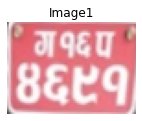

In [ ]:
# Viualize obtained plate images
#Here only one image is visualized 
fig = plt.figure(figsize=(12,6))
cols = 5
rows = 4
fig_list = []
k = 1

for i in range(20):
    try: 
        LpImg,_ = get_plate(image_paths[i])
    except Exception as e:
        continue
    fig_list.append(fig.add_subplot(rows,cols,k))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    plt.axis(False)
    plt.imshow(LpImg[0])
    k = k+1

plt.tight_layout(True)
plt.show()

**2. Reconstruction using SRGAN.**

Loading the trained model and then reconstructing the image.

In [1]:
from PIL import Image
import PIL
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model


from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#preprocessing
def normalize_LR(x):
  return np.divide(np.array(x, dtype=np.float32), 255.)
def denormalize_LR_HR(input_data):
  input_data = (input_data +1)*127.5
  return input_data.astype(np.uint8)
def resize_images(img):
  img_width = 70 #change for model
  img_height = 50 #change for model
  resized_image = []
  resized_image_rgb = []

  resized_image.append(
          np.array(
              PIL.Image.fromarray(img).resize(
                [img_width ,img_height], resample=PIL.Image.BICUBIC)))       
  return resized_image

(50, 70, 3)


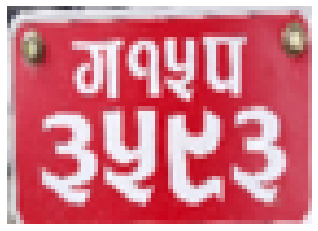

In [3]:
#loading
image1 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/ALPR/SISR/Figure/scooter_lr.jpg")
image1 = image1[:,:, [2,1,0]]
imager = resize_images(image1)
print(imager[0].shape)
plt.axis(False)
img = plt.imshow(imager[0], interpolation='nearest')
imagen = normalize_LR(imager)

(1, 200, 280, 3)


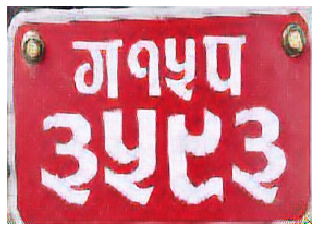

In [4]:
#model load and predict
model1 = load_model('/content/drive/MyDrive/Colab Notebooks/ALPR/SISR/ALPR_Distorted/model_output_4/gen_model_18_160.h5',compile=False) #change path for new model
gen_img = model1.predict(imagen)
print(gen_img.shape)
generated_image = denormalize_LR_HR(gen_img)
plt.axis(False)

Image.fromarray(generated_image[0]).save('/content/drive/MyDrive/Colab Notebooks/ALPR/SISR/Figure/bike_sr.jpg')
img = plt.imshow(generated_image[0], interpolation='nearest')
# plt.plot()

**3. Character Segmentation**
* Using contour/region based approach

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import glob
import matplotlib
from keras.preprocessing.image import load_img, img_to_array
from google.colab.patches import cv2_imshow
# %matplotlib.inline

Found 1 images...


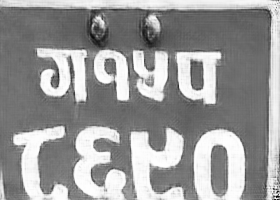

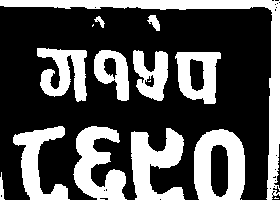

In [ ]:
image_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/ALPR/SISR/ALPR_Distorted/test_8_upscaled_images/sr_image/Copy of generated_image_3_8.png')
print("Found {} images...".format(len(image_paths)))

for i in range(1):

    plate_image = cv2.imread(image_paths[0])   

    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)

    # Applied inversed thresh_binary 
    binary = cv2.threshold(gray, 0, 255,
                         cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
cv2_imshow(gray)
cv2_imshow(binary)


Detect 8 letters...


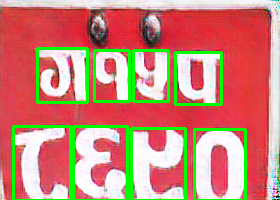

In [ ]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

cont, _  = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 50

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 0.5<=ratio<=2:# Only select contour with defined ratio
        # print(h/image.shape[0])
        if h/plate_image.shape[0]>=0.1: # Select contour which has the height larger than 20% of the plate
          if 7000>=(h*w)>=1000:

            # Draw bounding box arroung digit number
                cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
                curr_num = plate_image[y:y+h,x:x+w]
                curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            # _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                crop_characters.append(curr_num)
            
print("Detect {} letters...".format(len(crop_characters)))            
cv2_imshow(test_roi)


Visualizing segmented characters


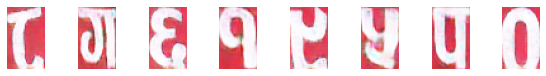

In [ ]:
fig = plt.figure(figsize=(8, 50))
cols = 8
rows = 50
fig_list = []
k = 1

for i in range(len(crop_characters)):
    crop_characters[i] = cv2.cvtColor(crop_characters[i], cv2.COLOR_BGR2RGB)
    fig_list.append(fig.add_subplot(rows,cols,k))
    plt.axis(False)
    plt.imshow(crop_characters[i])
    k = k+1

plt.tight_layout(True)
plt.show()

**4. Character Recognition**


In [ ]:
import os
from sklearn.externals import joblib

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Loading the model(svc.pkl) and predicting the characters.


In [ ]:
current_dir = '/content/drive/MyDrive/Colab Notebooks/ALPR/'

model_dir = os.path.join(current_dir, 'models/svc/svc.pkl')
model = joblib.load(model_dir) 

classification_result = []
for each_character in crop_characters:
    each_character = cv2.cvtColor(each_character, cv2.COLOR_BGR2GRAY)
    each_character = cv2.resize(each_character,(40, 40), interpolation = cv2.INTER_AREA )
    binary_image = cv2.threshold(each_character, 180, 255,
                         cv2.THRESH_BINARY)[1]
    # cv2_imshow(binary_image)
    each_character_final = binary_image.reshape(1, -1);

    result = model.predict(each_character_final)
    classification_result.append(result)

# print(classification_result)

plate_string = ''
for eachPredict in classification_result:
    plate_string += eachPredict[0]

print(plate_string)

८ग६१९५प०
